In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import numpy.ma as ma
import struct
import os
import xarray as xr
import glob
import datetime 
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns

# ESIO Imports
import esio
import esiodata as ed

In [2]:
# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [32]:
#############################################################
# Load in Data
#############################################################

E = ed.esiodata.load()

# Load in Obs
data_dir = E.data_dir
grid_dir = E.grid_dir
temp_dir = r'/home/disk/sipn/nicway/data/model/temp'
# fig_dir = os.path.join(E.fig_dir, 'obs', 'NSIDC_0081' , 'standard')
da_51_in = xr.open_dataarray(E.obs['NSIDC_0081']['sipn_nc']+'/NSIDC_0081.nc')
ds_ext = xr.open_dataset(os.path.join(E.obs['NSIDC_extent']['sipn_nc'], 'N_seaice_extent_daily_v3.0.nc'))

In [4]:
models = ['yopp']
runType = 'forecast'
variables = ['sic']

In [5]:
c_model = models[0]
cvar = variables[0]

In [6]:
# Load in Model
model_forecast = os.path.join(E.model[c_model][runType]['sipn_nc'], '*.nc')
ds_model = xr.open_mfdataset(model_forecast)
ds_model.rename({'nj':'x', 'ni':'y'}, inplace=True)

# Set attributes
ds_model.attrs['model_label'] = E.model[c_model]['model_label']
ds_model.attrs['model_grid_file'] = E.model[c_model]['grid']
ds_model.attrs['stero_grid_file'] = E.obs['NSIDC_0051']['grid']

In [7]:
# Load in regional data
# Note minor -0.000004 degree differences in latitude
ds_region = xr.open_dataset(os.path.join(E.grid_dir, 'sio_2016_mask.nc'))
ds_region.set_coords(['lat','lon'], inplace=True);
ds_region.rename({'nx':'x', 'ny':'y'}, inplace=True);

In [8]:
# Select by variable
da_mod_in = ds_model[cvar]

In [9]:
# Mask out to common extent (both observations and model have non-null values)
(da_obs, da_mod) = esio.mask_common_extent(da_51_in, da_mod_in)

In [10]:
# Calculate Sea Ice << EXTENT >>
da_obs_avg = ((da_obs>0.15).astype('int') * ds_region.area).sum(dim='x').sum(dim='y')/(10**6)
da_mod_avg = ((da_mod>0.15).astype('int') * ds_region.area).sum(dim='x').sum(dim='y')/(10**6)

In [11]:
da_mod_avg #.fore_time.values.astype('timedelta64[D]')

<xarray.DataArray (ensemble: 1, init_time: 48, fore_time: 85)>
dask.array<shape=(1, 48, 85), dtype=float64, chunksize=(1, 2, 85)>
Coordinates:
  * fore_time  (fore_time) timedelta64[ns] 0 days 00:00:00 0 days 03:00:00 ...
  * init_time  (init_time) datetime64[ns] 2018-03-01 2018-03-01T12:00:00 ...
Dimensions without coordinates: ensemble

In [12]:
# Force model and observations to have the same temporal time step (and slice or average)
# Get model and obs time step
dt_obs = (da_obs_avg.time[1] - da_obs_avg.time[0]).values # Time slices
dt_mod = (da_mod_avg.fore_time[1] - da_mod_avg.fore_time[0]).values
freq_dict = {np.timedelta64(86400000000000,'ns'):'1D', np.timedelta64(1,'M'):'MS'} # TODO: find a way to automate this....

# Aggregate to larger time step
if dt_obs > dt_mod:
    # Aggregate model to obs
    da_mod_avg_agg = da_mod_avg.resample(fore_time=freq_dict[dt_obs], label='left', keep_attrs=True).mean(dim='fore_time') # on fore_time
    da_mod_avg_agg = da_mod_avg_agg.resample(init_time=freq_dict[dt_obs], label='left', keep_attrs=True).mean(dim='init_time') # on init_time
    da_obs_avg_agg = da_obs_avg # pass through
elif dt_obs < dt_mod:
    # Aggregate obs to model
    da_obs_avg_agg = da_obs_avg.resample(time=freq_dict[dt_mod], label='left', keep_attrs=True).mean(dim='time')
    da_mod_avg_agg = da_mod_avg # pass through

In [13]:
da_mod_avg_agg

<xarray.DataArray (ensemble: 1, init_time: 24, fore_time: 16)>
dask.array<shape=(1, 24, 16), dtype=float64, chunksize=(1, 1, 1)>
Coordinates:
  * init_time  (init_time) datetime64[ns] 2018-03-01 2018-03-02 2018-03-03 ...
  * fore_time  (fore_time) timedelta64[ns] 0 days 1 days 2 days 3 days ...
Dimensions without coordinates: ensemble

In [14]:
# Trim to common time periods
(ds_obs_trim, ds_mod_trim) = esio.trim_common_times(da_obs_avg_agg, da_mod_avg_agg)

2018-03-01T00:00:00.000000000 2018-03-26T00:00:00.000000000


In [15]:
ds_ext = ds_ext.sel(datetime=ds_obs_trim.time)

In [16]:
# # Temp dump to netcdf then load
# os.chdir( temp_dir )
# c_e, datasets = zip(*ds_mod_trim.to_dataset(name='sic').groupby('ensemble'))
# paths = ['yopp_extent_esns_%s.nc' % e for e in c_e]
# xr.save_mfdataset(datasets, paths)

In [17]:
# print("Done!")

In [18]:
# ds_mod_trim = None # Flush memory

In [19]:
# ds_mod_trim = xr.open_mfdataset(os.path.join(temp_dir, 'GFDL_extent_esns_*.nc'), concat_dim='ensemble')

# ds_mod_trim = ds_mod_trim.reindex(ensemble=sorted(ds_mod_trim.ensemble.values))
# # 
# ds_mod_trim.fore_time.values.astype('timedelta64[D]')

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


Text(0.5,1,'')

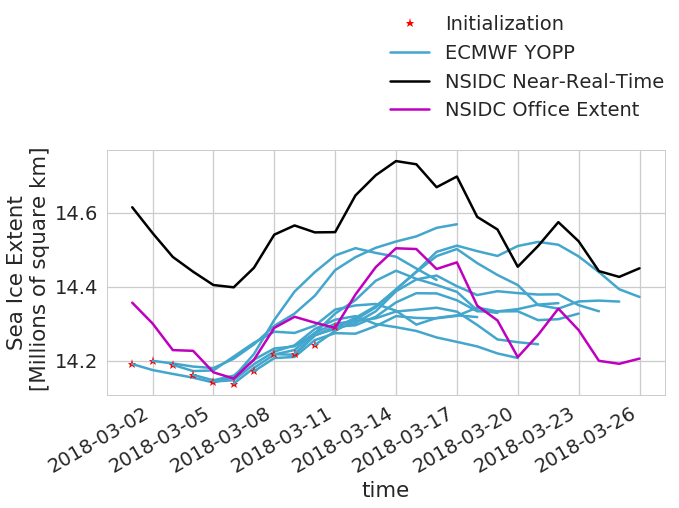

In [28]:
# Plot pan-Arctic sea ice extent
f = plt.figure(figsize=(10,5))
ax1 = plt.subplot(1, 1, 1) # Observations
esio.plot_reforecast(ds=ds_mod_trim, axin=ax1, labelin=ds_model.model_label,
                     color='cycle_ensemble', marker=None)
ds_obs_trim.plot(label='NSIDC Near-Real-Time', color='k')
ds_ext.Extent.plot(label='NSIDC Offical Extent', color='m')
ax1.set_ylabel('Sea Ice Extent\n [Millions of square km]')
plt.legend(loc='lower right',bbox_to_anchor=(1.03, 1.05))
f.autofmt_xdate()
plt.title('')

In [21]:
# Format obs like model
da_obs_avg_mon_X = esio.format_obs_like_model(ds_mod_trim, ds_obs_trim)

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


In [22]:
 # Get observational mean and sigma
(mu, sigma) = esio.clim_mu_sigma(da_obs_avg_agg, method='MK')

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


In [23]:
c_nrmse = esio.NRMSE(ds_mod_trim, da_obs_avg_mon_X, sigma)
print(c_nrmse)

<xarray.DataArray (init_time: 11)>
dask.array<shape=(11,), dtype=float64, chunksize=(1,)>
Coordinates:
  * init_time  (init_time) datetime64[ns] 2018-03-01 2018-03-02 2018-03-03 ...


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


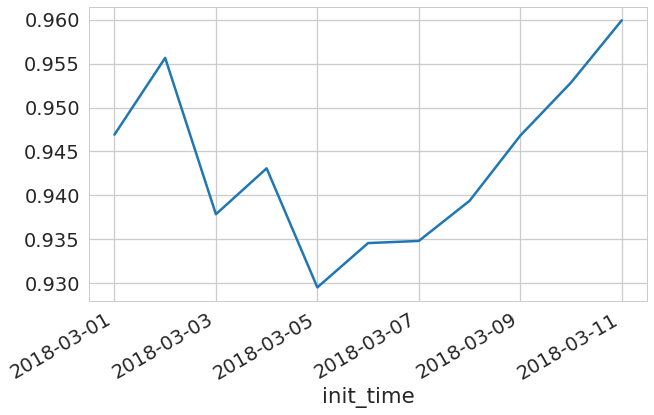

In [24]:
#NRMSE is following the same pattern per months as Hawkins et al. 2016.
f, ax1 = plt.subplots(1,1)
f.set_size_inches(10, 6)
c_nrmse.plot(ax=ax1)